In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas_datareader.data as web
from datetime import timedelta

```
my_tweets_df: daily, 0 for days no tweets
my_tsla_df: weekdays, interpolate for weekend data
my_doge_df: start date: 2020-07-30, daily
my_sp_df: weekdays, interpolate for weekend data
my_google_df:
my_crypto_df: start date: 2017-02-28


```

# Load Data

## Twitter Data

### Kaggle Twitter Data

example: 2017 data 

url:
`https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/elon_tweets_2017.csv`

In [2]:
#function to index and clean Elon musk tweet data from github repo 

#year: str, no spaces
#possible years: [2017 - 2021]

def get_yearly_elon_tweets(year):
  
  #define url 
  url_a = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/elon_tweets_'
  url_b = year
  url_c = '.csv'
  url = url_a + url_b + url_c

  #read data
  df = pd.read_csv(url, parse_dates=['date'])
  
  #index with date (no hourly)
  df.index = pd.DatetimeIndex(df['date']).floor('D')
  
  #data cleaning, only tweets in coresponding year
  start_date = year + '0101' 
  end_date = year + '1231' 
  query_str = start_date + ' <= date <= ' + end_date
  df = df.query(query_str)
  return(df)


In [3]:
df_2017 = get_yearly_elon_tweets('2017')
df_2018 = get_yearly_elon_tweets('2018')
df_2019 = get_yearly_elon_tweets('2019')
df_2020 = get_yearly_elon_tweets('2020')
df_2021 = get_yearly_elon_tweets('2021')

In [4]:
tweet_df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021], axis=0)

In [5]:
tweet_df.shape

(10218, 39)

In [6]:
#excludes tweet replies
tweet_df = tweet_df[tweet_df['reply_to'] == '[]']

In [7]:
tweet_df.shape

(2585, 39)

In [8]:
#extract column of interest, nlikes
my_tweet_df = pd.concat([tweet_df['nlikes']], names=['nlikes'], axis=1)

In [9]:
#average daily number of likes 
my_tweet_df = my_tweet_df.resample('D').mean()

In [10]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

In [11]:
#what percentage are missing values?
nan_perc = my_tweet_df.isna().sum() / my_tweet_df.isna().count()
print("Elon did not tweet on {:.1f}% of days in 2017-2021".format(
    nan_perc.nlikes*100))

Elon did not tweet on 39.7% of days in 2017-2021


In [12]:
#for days with no tweets, fill with zero
my_tweet_df = my_tweet_df.reindex(all_dates, fill_value=0)

In [13]:
my_tweet_df['3/23/2021':'12/31/2021']['nlikes'] = np.NaN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


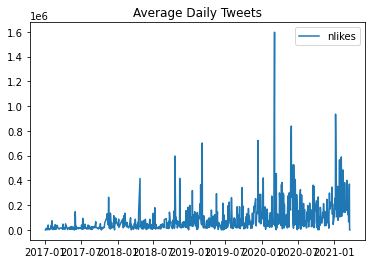

In [14]:
sns.lineplot(data=my_tweet_df)
plt.title('Average Daily Tweets')
plt.show()

In [15]:
my_tweet_df.head()

,nlikes
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,14041.0


In [16]:
my_tweet_df.tail()

,nlikes
2021-12-27,NaN
2021-12-28,NaN
2021-12-29,NaN
2021-12-30,NaN
2021-12-31,NaN


In [17]:
my_tweet_df.shape

(1826, 1)

### Twitter API Data

Data in repo: https://www.github.com/rae-fahrenholtz/Elon

In [18]:
import base64
import requests
import pandas as pd
import json

In [19]:
# function to extract number of likes and date of tweet from json data from
# Twitter API

# Data is in repo https://www.github.com/rae-fahrenholtz/Elon

# url: str, link to json data

def my_json_to_df(url):
    master = url
    req = requests.get(master)
    req = req.text                        #json as string
    d = json.loads(req)                   #json as dict
    ntweets = len(d['data'])              #num of tweets
    likes = []                            #initialize lists
    date = []                
    
    for i in range(ntweets):              #extract nlikes and date from dict
        likes.append(d['data'][i]
                     ['public_metrics']['like_count'])
        date.append(d['data'][i]['created_at'][0:10])
    
    date_datetime = pd.to_datetime(date)  #convert to datetime index
    nlikes_s = pd.Series(likes, index=date_datetime, name='nlikes')
    nlikes_df = pd.DataFrame(nlikes_s)                                           
    nlikes_df = nlikes_df.sort_index()    #reorders date from oldest to newest
    
    return(nlikes_df)

In [20]:
url1 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2022-01-31'
url2 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-12-01'
url3 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-09-02'
url4 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-06-25'
url5 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-04-15'
url6 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-02-25'

consider:
```
frames = [ process_your_file(f) for f in files ]
result = pd.concat(frames)
```

In [21]:
api_tweet1_df = my_json_to_df(url1)
api_tweet2_df = my_json_to_df(url2)
api_tweet3_df = my_json_to_df(url3)
api_tweet4_df = my_json_to_df(url4)
api_tweet5_df = my_json_to_df(url5)
api_tweet6_df = my_json_to_df(url6)

In [22]:
api_tweets_df = pd.concat([api_tweet1_df, api_tweet2_df, api_tweet3_df, api_tweet4_df, api_tweet5_df, api_tweet6_df], axis=0)

In [23]:
api_tweets_df.shape

(600, 1)

In [24]:
#sorts dates from oldest to newest
api_tweets_df = api_tweets_df.sort_index()

In [25]:
my_api_tweets = api_tweets_df['03/21/21':'12/31/21']

In [26]:
#average daily number of likes 
my_api_tweets = my_api_tweets.resample('D').mean()

In [27]:
#fill missing values with 0 
my_api_tweets = my_api_tweets.fillna(0)

In [28]:
my_api_tweets.head()

,nlikes
2021-03-23,446216.0
2021-03-24,393710.0
2021-03-25,394930.0
2021-03-26,0.0
2021-03-27,569011.0


### Combine Kaggle Tweets and API Tweets

In [29]:
my_api_tweets.head()

,nlikes
2021-03-23,446216.0
2021-03-24,393710.0
2021-03-25,394930.0
2021-03-26,0.0
2021-03-27,569011.0


In [30]:
my_tweet_df.head()

,nlikes
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,14041.0


In [31]:
my_tweet_df.tail()

,nlikes
2021-12-27,NaN
2021-12-28,NaN
2021-12-29,NaN
2021-12-30,NaN
2021-12-31,NaN


In [32]:
#remove dates with missing values ('03-23-2021':'12-31-21')
my_tweet_df = my_tweet_df['01-01-2017':'03-22-2021']

In [33]:
my_tweet_df.tail()

,nlikes
2021-03-18,164435.333333
2021-03-19,327982.000000
2021-03-20,370258.000000
2021-03-21,0.000000
2021-03-22,0.000000


In [34]:
my_api_tweets.head()

,nlikes
2021-03-23,446216.0
2021-03-24,393710.0
2021-03-25,394930.0
2021-03-26,0.0
2021-03-27,569011.0


In [35]:
my_tweets_df = pd.concat([my_tweet_df, my_api_tweets], axis = 0)

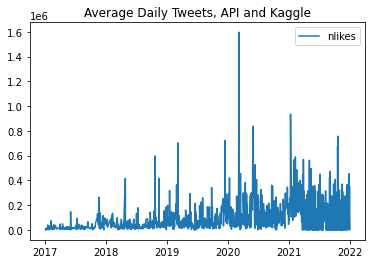

In [36]:
sns.lineplot(data=my_tweets_df)
plt.title('Average Daily Tweets, API and Kaggle')
plt.show()

## TSLA Data

In [37]:
!pip install finnhub-python

In [38]:
import finnhub

In [39]:
finnhub_client = finnhub.Client(api_key="c7h1h52ad3ibsjtt5ug0")

In [40]:
print(datetime.date.fromtimestamp(1483228800))

2017-01-01


In [41]:
print(datetime.date.fromtimestamp(1640908800))

2021-12-31


In [42]:
epoch_start_date = 1483228800
epoch_end_date = 1640908800

In [43]:
#display the high, low, open, and closing prices of a security for a specific 
#period in epoch time (1/1/2017 - 12/31/2021)
tsla_candle_df = pd.DataFrame(finnhub_client.stock_candles(
    'TSLA', 'D', epoch_start_date, epoch_end_date))

In [44]:
#create time column in YYYY-MM-DD format
tsla_candle_df['date'] = pd.to_datetime(tsla_candle_df['t'],unit='s')
tsla_candle_df['day_of_week'] = pd.to_datetime(tsla_candle_df['t'],unit='s').dt.day_name()

In [45]:
tsla_candle_df = tsla_candle_df.set_index('date')

In [46]:
# extract closing column ('c') with same index
my_tsla_df = pd.DataFrame(tsla_candle_df['c'], index=tsla_candle_df.index)
my_tsla_df = my_tsla_df.rename(columns={'c': 'tsla'})

In [47]:
my_tsla_df.head()

,tsla
date,
2017-01-03,43.398
2017-01-04,45.398
2017-01-05,45.350
2017-01-06,45.802
2017-01-09,46.256


In [48]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

In [49]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_tsla_df = my_tsla_df.reindex(all_dates)

In [50]:
my_tsla_df.head()

,tsla
2017-01-01,NaN
2017-01-02,NaN
2017-01-03,43.398
2017-01-04,45.398
2017-01-05,45.350


In [51]:
#fill missing values with interpolate
#limit_direction = 'both' estimates both forward and backward projections

my_tsla_df['tsla'] = my_tsla_df['tsla'].fillna(my_tsla_df['tsla'].interpolate(limit_direction='both'))

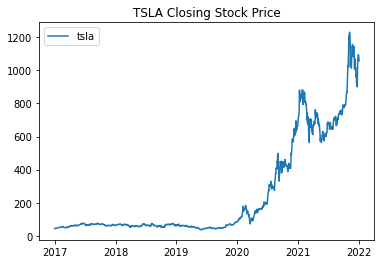

In [52]:
sns.lineplot(data=my_tsla_df)
plt.title('TSLA Closing Stock Price')
plt.show()

In [53]:
my_tsla_df.head()

,tsla
2017-01-01,43.398
2017-01-02,43.398
2017-01-03,43.398
2017-01-04,45.398
2017-01-05,45.350


In [54]:
my_tsla_df.shape

(1826, 1)

## DOGE Data

In [55]:
cryptos = pd.DataFrame(finnhub_client.crypto_symbols('BINANCE'))

In [56]:
print(datetime.date.fromtimestamp(1483228800))

2017-01-01


In [57]:
print(datetime.date.fromtimestamp(1640908800))

2021-12-31


In [58]:
epoch_start_date = 1483228800
epoch_end_date = 1640908800

In [59]:
doge_candle_df = pd.DataFrame(finnhub_client.crypto_candles('BINANCE:DOGEBUSD', 
                                                            'D', 
                                                            epoch_start_date, 
                                                            epoch_end_date))

In [60]:
#create time column in YYYY-MM-DD format
doge_candle_df['date'] = pd.to_datetime(doge_candle_df['t'], unit='s')
doge_candle_df['day_of_week'] = pd.to_datetime(doge_candle_df['t'],unit='s').dt.day_name()

In [61]:
print("Only {} days of data for DOGE".format(len(doge_candle_df)))

Only 500 days of data for DOGE


In [62]:
doge_candle_df.head(20)

,c,h,l,o,s,t,v,date,day_of_week
0,0.003232,0.003902,0.003156,0.003158,ok,1596067200,3525952.0,2020-07-30,Thursday
1,0.003222,0.003238,0.003190,0.003218,ok,1596153600,3263112.0,2020-07-31,Friday
2,0.003713,0.003877,0.003234,0.003234,ok,1596240000,51932054.0,2020-08-01,Saturday
3,0.003346,0.003737,0.003068,0.003718,ok,1596326400,23081112.0,2020-08-02,Sunday
4,0.003386,0.003450,0.003298,0.003327,ok,1596412800,5931436.0,2020-08-03,Monday
5,0.003535,0.003557,0.003357,0.003390,ok,1596499200,14747779.0,2020-08-04,Tuesday
6,0.003512,0.003576,0.003473,0.003542,ok,1596585600,11009273.0,2020-08-05,Wednesday
7,0.003556,0.003649,0.003460,0.003520,ok,1596672000,34458067.0,2020-08-06,Thursday
8,0.003494,0.003621,0.003355,0.003583,ok,1596758400,20431565.0,2020-08-07,Friday
9,0.003507,0.003534,0.003399,0.003466,ok,1596844800,24085065.0,2020-08-08,Saturday


In [63]:
doge_candle_df = doge_candle_df.set_index('date')

In [64]:
doge_candle_df.head()

,c,h,l,o,s,t,v,day_of_week
date,,,,,,,,
2020-07-30,0.003232,0.003902,0.003156,0.003158,ok,1596067200,3525952.0,Thursday
2020-07-31,0.003222,0.003238,0.003190,0.003218,ok,1596153600,3263112.0,Friday
2020-08-01,0.003713,0.003877,0.003234,0.003234,ok,1596240000,51932054.0,Saturday
2020-08-02,0.003346,0.003737,0.003068,0.003718,ok,1596326400,23081112.0,Sunday
2020-08-03,0.003386,0.003450,0.003298,0.003327,ok,1596412800,5931436.0,Monday


In [65]:
# extract closing column ('c') with same index
my_doge_df = pd.DataFrame(doge_candle_df['c'], index=doge_candle_df.index)
my_doge_df = my_doge_df.rename(columns={'c':'doge'})

In [66]:
my_doge_df.head()

,doge
date,
2020-07-30,0.003232
2020-07-31,0.003222
2020-08-01,0.003713
2020-08-02,0.003346
2020-08-03,0.003386


In [67]:
# no missing values, data is for all days of the week
my_doge_df['doge'].isnull().sum() 

0

In [68]:
print("The first day of DOGE data is {}.".format(my_doge_df.index[0]))

The first day of DOGE data is 2020-07-30 00:00:00.


In [69]:
#reindex for all dates, same format as other df
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

In [70]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_doge_df = my_doge_df.reindex(all_dates)

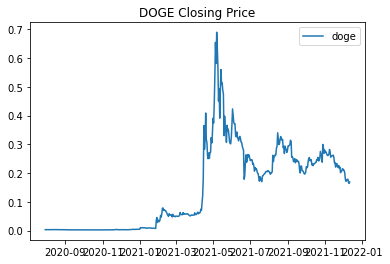

In [71]:
sns.lineplot(data=my_doge_df)
plt.title('DOGE Closing Price')
plt.show()

In [72]:
my_doge_df.head()

,doge
2017-01-01,NaN
2017-01-02,NaN
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN


In [73]:
my_doge_df.shape

(1826, 1)

### S&P500 Index Data

In [74]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2021, 12, 31)

In [75]:
my_sp_df = web.DataReader(['sp500'], 'fred', start_date, end_date)

In [76]:
#rename index 
my_sp_df.index = my_sp_df.index.rename('date')

In [77]:
my_sp_df.head()

,sp500
date,
2017-01-02,NaN
2017-01-03,2257.83
2017-01-04,2270.75
2017-01-05,2269.00
2017-01-06,2276.98


In [78]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

In [79]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_sp_df = my_sp_df.reindex(all_dates)

In [80]:
my_sp_df.isnull().sum() / my_sp_df.isnull().count()

sp500    0.310515
dtype: float64

In [81]:
#fill missing values with interpolate
#limit_direction = 'both' estimates both forward and backward projections

my_sp_df['sp500'] = my_sp_df['sp500'].fillna(my_sp_df['sp500'].interpolate(limit_direction='both'))

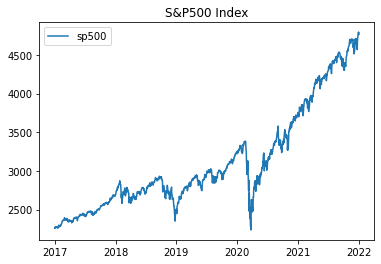

In [82]:
sns.lineplot(data=my_sp_df)
plt.title('S&P500 Index')
plt.show()

In [83]:
my_sp_df.head()

,sp500
2017-01-01,2257.83
2017-01-02,2257.83
2017-01-03,2257.83
2017-01-04,2270.75
2017-01-05,2269.00


In [84]:
my_sp_df.shape

(1826, 1)

### Google Data

pytrends (google trends api)
-relative popularity (not absolute)

In [85]:
!pip install pytrends

In [86]:
from pytrends.request import TrendReq

In [87]:
#build model
pytrend = TrendReq()

In [88]:
#provide your search terms
kw_list = ['Elon Musk']
pytrend.build_payload(kw_list=kw_list)

In [89]:
#historical interest
historicaldf = pytrend.get_historical_interest(kw_list, 
                                                year_start=2017, month_start=1, day_start=1, hour_start=0,
                                                year_end=2021, month_end=12, day_end=31, hour_end=0, 
                                                cat=0, geo='', gprop='', sleep=0)

In [90]:
historicaldf.keys()

Index(['Elon Musk', 'isPartial'], dtype='object')

`'isPartial'` key is a column of all `'False'`

In [91]:
historicaldf['isPartial'].head()

date
2017-01-01 00:00:00    False
2017-01-01 01:00:00    False
2017-01-01 02:00:00    False
2017-01-01 03:00:00    False
2017-01-01 04:00:00    False
Name: isPartial, dtype: bool

In [92]:
historicaldf['isPartial'].unique()

array([False])

In [93]:
#hourly relative popularity for 'Elon Musk' searches
historicaldf['Elon Musk'].head(20)

date
2017-01-01 00:00:00    55
2017-01-01 01:00:00    61
2017-01-01 02:00:00    64
2017-01-01 03:00:00    53
2017-01-01 04:00:00    51
2017-01-01 05:00:00    46
2017-01-01 06:00:00    49
2017-01-01 07:00:00    42
2017-01-01 08:00:00    41
2017-01-01 09:00:00    41
2017-01-01 10:00:00    65
2017-01-01 11:00:00    42
2017-01-01 12:00:00    36
2017-01-01 13:00:00    38
2017-01-01 14:00:00    43
2017-01-01 15:00:00    41
2017-01-01 16:00:00    43
2017-01-01 17:00:00    43
2017-01-01 18:00:00    45
2017-01-01 19:00:00    56
Name: Elon Musk, dtype: int64

In [94]:
#daily average popularity 
daily_series = historicaldf['Elon Musk'].resample('D').mean()

In [95]:
print(daily_series)

date
2017-01-01    49.208333
2017-01-02    51.250000
2017-01-03    50.833333
2017-01-04    53.583333
2017-01-05    52.625000
                ...    
2021-12-27    65.833333
2021-12-28    69.416667
2021-12-29    72.208333
2021-12-30    74.708333
2021-12-31    84.000000
Freq: D, Name: Elon Musk, Length: 1826, dtype: float64


In [96]:
my_google_df = pd.DataFrame(daily_series, index=daily_series.index)

In [97]:
#rename column from 'Elon Musk' to 'google'
my_google_df = my_google_df.rename(columns={"Elon Musk": "google"})

In [98]:
my_google_df.head()

,google
date,
2017-01-01,49.208333
2017-01-02,51.250000
2017-01-03,50.833333
2017-01-04,53.583333
2017-01-05,52.625000


In [99]:
#######TODO
#Consider data cleaning for zeros between 2/25/2020-3/1/2020

In [100]:
my_google_df[my_google_df['google']==0]

,google
date,
2020-02-25,0.0
2020-02-26,0.0
2020-02-27,0.0
2020-02-28,0.0
2020-02-29,0.0
2020-03-01,0.0
2020-03-15,0.0
2020-03-16,0.0
2021-08-01,0.0


Text(0.5, 1.0, 'Google Searches, Elon Musk relative popularity')

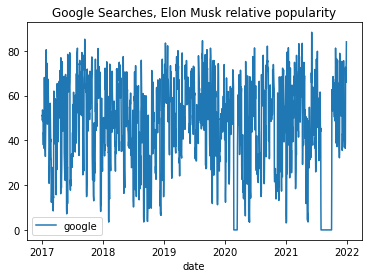

In [101]:
sns.lineplot(data=my_google_df)
plt.title('Google Searches, Elon Musk relative popularity')

In [102]:
my_google_df.head()

,google
date,
2017-01-01,49.208333
2017-01-02,51.250000
2017-01-03,50.833333
2017-01-04,53.583333
2017-01-05,52.625000


In [103]:
my_google_df.shape

(1826, 1)

### Crypto Index Data

https://www.spglobal.com/spdji/en/indices/digital-assets/sp-cryptocurrency-bdm-ex-largecap-index/

In [104]:
url = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/cyrtoSandP.csv'

In [105]:
#includes extra unnecessary unnamed columns 
df_raw = pd.read_csv(url, index_col='date')

In [106]:
df_raw.head()

,price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
date,,,,,,
2/28/17,100.00,NaN,NaN,NaN,NaN,NaN
3/1/17,105.04,NaN,NaN,NaN,NaN,NaN
3/2/17,120.77,NaN,NaN,NaN,NaN,NaN
3/3/17,122.89,NaN,NaN,NaN,NaN,NaN
3/6/17,123.24,NaN,NaN,NaN,NaN,NaN


In [107]:
my_crypto_df = df_raw[['price']].copy()

In [108]:
my_crypto_df.index = pd.to_datetime(my_crypto_df.index)

In [109]:
my_crypto_df = my_crypto_df.rename(columns={'price': 'crypto'})

In [110]:
my_crypto_df.head()

,crypto
date,
2017-02-28,100.00
2017-03-01,105.04
2017-03-02,120.77
2017-03-03,122.89
2017-03-06,123.24


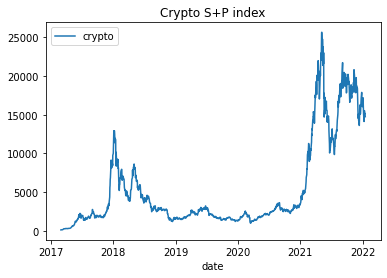

In [111]:
sns.lineplot(data=my_crypto_df)
plt.title('Crypto S+P index')
plt.show()

In [112]:
print("The first day of crypto index data is {}.".format(my_crypto_df.index[0]))

The first day of crypto index data is 2017-02-28 00:00:00.


In [113]:
my_crypto_df.head()

,crypto
date,
2017-02-28,100.00
2017-03-01,105.04
2017-03-02,120.77
2017-03-03,122.89
2017-03-06,123.24


In [114]:
#reindex for all dates, same format as other df
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

In [115]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_crypto_df = my_crypto_df.reindex(all_dates)

In [116]:
my_crypto_df.head()

,crypto
2017-01-01,NaN
2017-01-02,NaN
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN


In [117]:
my_crypto_df.shape

(1826, 1)

### Getting all data together

```
my_tweets_df: daily, 0 for days no tweets
my_tsla_df: weekdays, interpolate for weekend data
my_doge_df: start date: 2020-07-30, daily
my_sp_df: weekdays, interpolate for weekend data
my_google_df:
my_crypto_df: start date: 2017-02-28


```

In [120]:
my_elon_df = pd.concat([my_tweets_df, my_tsla_df, my_doge_df, my_sp_df, my_google_df, my_crypto_df], axis=1)

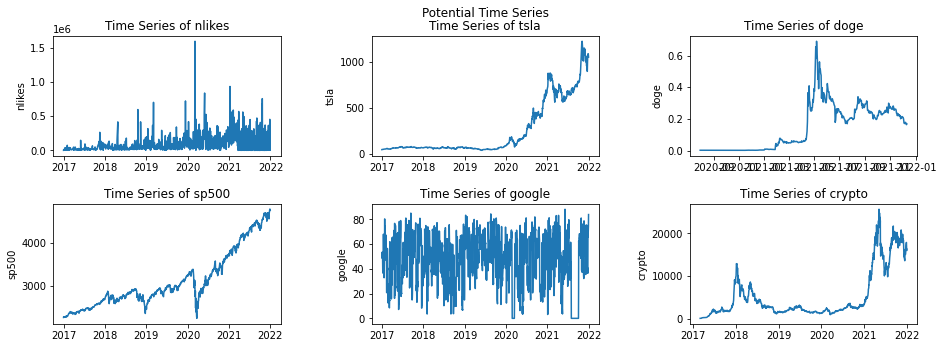

In [143]:
plt.figure(figsize = (15,5))
plt.suptitle('Potential Time Series')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for i, col in enumerate(my_elon_df.columns):
  plt.subplot(2, 3, i+1)
  sns.lineplot(data=my_elon_df, x=my_elon_df.index, y=col)
  plt.title("Time Series of {}".format(col))
#plt.savefig('')
#files.download('') 
plt.show()